In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from tqdm import tqdm

import numpy as np
import pandas as pd
import re, os, sys

import seaborn as sns
sns.set_style('white')

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
mpl.rcParams['pdf.fonttype'] = 42

import math

font_name = {'fontname':'Arial'}

plt.rcParams["font.family"] = "Arial"


In [3]:
# parameter settings

GPNotebook_dir = r"/Users/yingweihu/Documents/GitHub/GPNotebook"
data_name = "PDAC"

# working directory, wd
wd = os.path.join(GPNotebook_dir,"sample",data_name)
# input meta path: standardrized meta table
meta_path = os.path.join(wd,"meta/info.tsv")
# input expression matrix path
data_dir = os.path.join(wd,"data")
expr_path = os.path.join(data_dir,"PDA_JHU_GENCODEv34_nglycoform-peptide_matrix-abundances-MD_norm.tsv")

# create folders for generating results
result_dir = os.path.join(wd,"result")

if not os.path.exists(result_dir):
    os.mkdir(result_dir)
    
tool_dir = os.path.join(result_dir,"GPNotebook")
if not os.path.exists(tool_dir):
    os.mkdir(tool_dir)
    
job_dir = os.path.join(tool_dir,"survival_analysis")
if not os.path.exists(job_dir):
    os.mkdir(job_dir)
    
out_z_data_path = os.path.join(job_dir,'z_data.tsv.joblib')
out_fig_UniCOX_path = os.path.join(job_dir, "univariate_cox_curve.svg")
out_data_UniCOX_path = os.path.join(job_dir, "univariate_cox_data.tsv")

# print file location and verify the file path
print("Parameters")
print(f'--meta {meta_path}',
     os.path.exists(meta_path))

print(f'--expr {expr_path}',
     os.path.exists(expr_path))
print(f'--output_idr {job_dir}',
     os.path.exists(job_dir))


# column name in meta table for event, 1 for dead, 0 for alive
e = 'VitalStatus'
# nan value: unknown
nan_value = 'Unknown'
# label for living
l = 'Living'
# label for death
d = 'Deceased'
# column name in meta table for survival days
days = 'SurvivalDays'

Parameters
--meta /Users/yingweihu/Documents/GitHub/GPNotebook/sample/PDAC/meta/info.tsv True
--expr /Users/yingweihu/Documents/GitHub/GPNotebook/sample/PDAC/data/PDA_JHU_GENCODEv34_nglycoform-peptide_matrix-abundances-MD_norm.tsv True
--output_idr /Users/yingweihu/Documents/GitHub/GPNotebook/sample/PDAC/result/GPNotebook/survival_analysis True


In [4]:
import joblib 

In [5]:
z_df = joblib.load(out_z_data_path)

In [6]:
z_df

,"(ADGTVNQIEGEATPVNLTEPAK-N4H5F1S1G0, APOD|ENSG00000189058.9)","(EVNDTLLVNELK-N5H5F1S1G0, POSTN|ENSG00000133110.15)","(SINVTGQGFSLIQR-N2H9F0S0G0, PLXNB2|ENSG00000196576.15)","(SLTQGSLIVGDLAPVNGTSQGK-N4H5F2S0G0, HSPG2|ENSG00000142798.20)","(VVANGTGTQGQLK-N2H5F0S0G0, GUSB|ENSG00000169919.17)","(DQCIVDDITYNVNDTFHK-N3H4F1S0G0, FN1|ENSG00000115414.20)","(MLEAYNLTEK-N2H8F0S0G0, COL12A1|ENSG00000111799.21)","(IADTNITSIPQGLPPSLTELHLDGNK-N4H5F0S1G0, DCN|ENSG00000011465.17)","(LHINHNNLTESVGPLPK-N4H5F2S0G0, LUM|ENSG00000139329.5)","(LHINHNNLTESVGPLPK-N4H5F1S2G0, LUM|ENSG00000139329.5)",...,"(ALPQPQNVTSLLGCTH-N6H3F1S2G0, HPX|ENSG00000110169.11)","(FQAFANGSLLIPDFGK-N3H5F1S1G0, ISLR|ENSG00000129009.13)","(LGLSFNSISAVDNGSLANTPHLR-N5H4F1S1G0, DCN|ENSG00000011465.17)","(TTLVDNNTWNNSHIALVGK-N2H8F0S0G0, STT3B|ENSG00000163527.10)","(NETLALPAESK-N4H5F1S1G0, ABI3BP|ENSG00000154175.17)","(EGPEQVIPINSGDLFVHPLWNR-N5H5F2S0G0, CELA3B|ENSG00000219073.8)","(NNSIPDK-N2H6F0S0G0, MFGE8|ENSG00000140545.15)","(SENASLVLSSSNQK-N2H7F0S0G0, ITGA1|ENSG00000213949.10)",T,E
C3N-01715.T,-0.352471,-1.394212,1.081268,-0.953489,-0.605735,-0.274263,1.171881,-0.867781,0.981550,0.014858,...,0.246236,-1.776201,-0.536928,1.087566,-2.068157,0.132239,-1.029283,-1.608522,108.0,True
C3N-03426.T,-0.225557,0.211637,-1.815535,-0.881718,0.708935,0.814634,-0.104783,-1.755147,-1.093348,-1.504497,...,-0.793549,-1.828400,-0.518092,-0.505203,-2.146305,-0.100299,0.160715,-1.386537,122.0,True
C3N-00198.T,-0.556182,1.268263,1.076877,0.545297,0.653684,-0.667581,-0.954164,1.171852,1.553963,1.604876,...,-0.227786,-0.468033,1.942861,-0.372649,0.297131,0.415590,0.015201,0.246930,1364.0,False
C3N-01380.T,0.512180,-0.324247,-0.032890,-0.653507,0.364133,-1.852850,-1.602847,2.293171,1.016179,2.317931,...,1.618452,-0.216358,0.013110,0.180925,1.861640,-4.417644,0.485078,-0.126862,400.0,True
C3N-01388.T,0.501879,0.054769,-0.064851,-0.736541,1.031554,0.210050,0.963682,0.072526,-1.516211,-0.552835,...,-0.729981,0.511481,-1.062865,-0.239580,-1.278978,0.395786,0.610033,0.336166,810.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C3L-00277.T,0.515068,1.674047,-2.193641,0.808321,0.011607,1.405453,-0.508438,0.204515,0.869970,1.171109,...,1.311911,1.155233,1.998254,-3.230824,-1.343718,0.541445,2.324758,-1.936183,610.0,True
C3L-01328.T,-0.887524,-0.701168,-0.811670,-0.487862,0.828323,1.282455,1.561355,-0.157074,1.592472,-0.085955,...,-1.776290,-1.179152,-0.568102,0.049425,0.274247,-1.324962,1.662463,-0.333356,270.0,False
C3L-03639.T,0.709910,-1.441874,0.765790,-0.838576,-0.070247,0.566921,-0.527139,-1.368010,1.782218,-0.673497,...,0.042232,-2.129507,-0.879181,1.544603,-1.094116,-0.886570,-0.071328,0.744147,246.0,True
C3N-04282.T,1.016017,-1.439377,-1.146560,-1.402773,-0.695864,0.932001,-0.013529,-0.835712,-0.699796,-0.842409,...,-1.480158,0.510596,-0.187595,0.391309,-1.150702,-0.004952,0.561642,-0.170261,303.0,True


In [21]:


from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold

from sklearn import set_config

from sklearn.model_selection import train_test_split


from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)



In [22]:
z_df2 = z_df.copy(deep=True)
aux = [(row['E'],row['T']) for index,row in z_df2.iterrows()]

#Structured array
y = np.array(aux, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [23]:
z_df2.head(2)

,"(ADGTVNQIEGEATPVNLTEPAK-N4H5F1S1G0, APOD|ENSG00000189058.9)","(EVNDTLLVNELK-N5H5F1S1G0, POSTN|ENSG00000133110.15)","(SINVTGQGFSLIQR-N2H9F0S0G0, PLXNB2|ENSG00000196576.15)","(SLTQGSLIVGDLAPVNGTSQGK-N4H5F2S0G0, HSPG2|ENSG00000142798.20)","(VVANGTGTQGQLK-N2H5F0S0G0, GUSB|ENSG00000169919.17)","(DQCIVDDITYNVNDTFHK-N3H4F1S0G0, FN1|ENSG00000115414.20)","(MLEAYNLTEK-N2H8F0S0G0, COL12A1|ENSG00000111799.21)","(IADTNITSIPQGLPPSLTELHLDGNK-N4H5F0S1G0, DCN|ENSG00000011465.17)","(LHINHNNLTESVGPLPK-N4H5F2S0G0, LUM|ENSG00000139329.5)","(LHINHNNLTESVGPLPK-N4H5F1S2G0, LUM|ENSG00000139329.5)",...,"(ALPQPQNVTSLLGCTH-N6H3F1S2G0, HPX|ENSG00000110169.11)","(FQAFANGSLLIPDFGK-N3H5F1S1G0, ISLR|ENSG00000129009.13)","(LGLSFNSISAVDNGSLANTPHLR-N5H4F1S1G0, DCN|ENSG00000011465.17)","(TTLVDNNTWNNSHIALVGK-N2H8F0S0G0, STT3B|ENSG00000163527.10)","(NETLALPAESK-N4H5F1S1G0, ABI3BP|ENSG00000154175.17)","(EGPEQVIPINSGDLFVHPLWNR-N5H5F2S0G0, CELA3B|ENSG00000219073.8)","(NNSIPDK-N2H6F0S0G0, MFGE8|ENSG00000140545.15)","(SENASLVLSSSNQK-N2H7F0S0G0, ITGA1|ENSG00000213949.10)",T,E
C3N-01715.T,-0.352471,-1.394212,1.081268,-0.953489,-0.605735,-0.274263,1.171881,-0.867781,0.981550,0.014858,...,0.246236,-1.776201,-0.536928,1.087566,-2.068157,0.132239,-1.029283,-1.608522,108.0,True
C3N-03426.T,-0.225557,0.211637,-1.815535,-0.881718,0.708935,0.814634,-0.104783,-1.755147,-1.093348,-1.504497,...,-0.793549,-1.828400,-0.518092,-0.505203,-2.146305,-0.100299,0.160715,-1.386537,122.0,True


In [24]:
rdf2 = joblib.load(out_data_UniCOX_path + 'joblib')

In [25]:
#%%
X = z_df2.drop(['E','T'],axis=1)
X = X.loc[:,list(rdf2['IGP'])]

In [26]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y["Status"], random_state=42
)

In [27]:
x_train.shape,x_test.shape

((77, 20), (20, 20))

In [28]:

y_events = y_train[y_train['Status']]
print(len(y_events))
train_min, train_max = y_events["Survival_in_days"].min(), y_events["Survival_in_days"].max()

y_events = y_test[y_test['Status']]
print(len(y_events))
test_min, test_max = y_events["Survival_in_days"].min(), y_events["Survival_in_days"].max()

print(train_min,train_max)
print(test_min,test_max)

assert train_min <= test_min < test_max < train_max, \
    "time range or test data is not within time range of training data."

44
12
1.0 1001.0
68.0 810.0


In [29]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(x_train, y_train)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

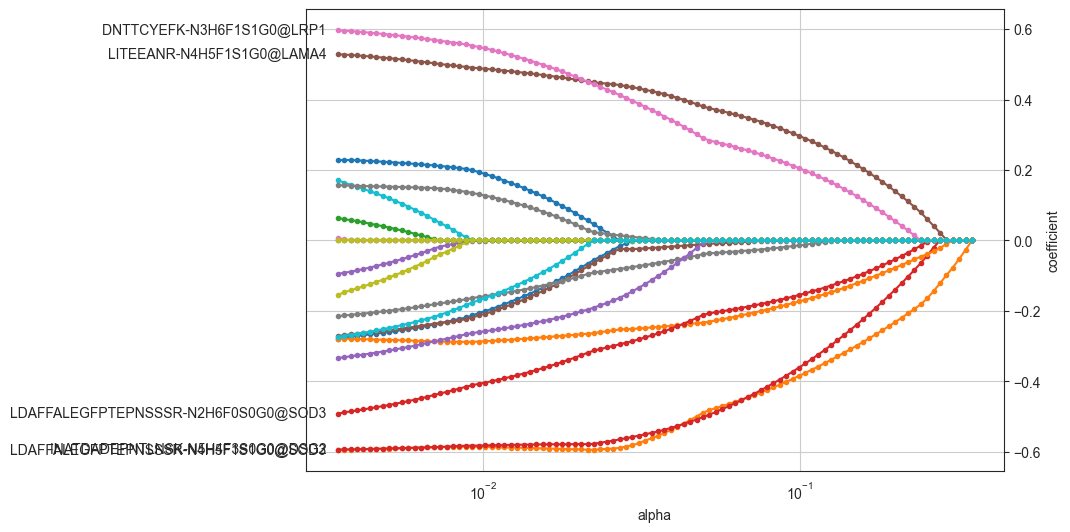

In [35]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_,
    index=X.columns,
    columns=np.round(cox_elastic_net.alphas_, 5)
)

def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
#         print(name)
        coef = coefs.loc[[name], alpha_min][0]
#         print(coef)
        plt.text(
            alpha_min, coef, 
            '{}@{}'.format(name[0],name[1].split("|")[0]) + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

plot_coefficients(coefficients_elastic_net, n_highlight=5)

In [36]:
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

coxnet_pipe = make_pipeline(
    # StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100)
)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(x_train, y_train)

Pipeline(steps=[('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9,
                                        max_iter=100))])

In [37]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline( CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1).fit(x_train, y_train)

cv_results = pd.DataFrame(gcv.cv_results_)

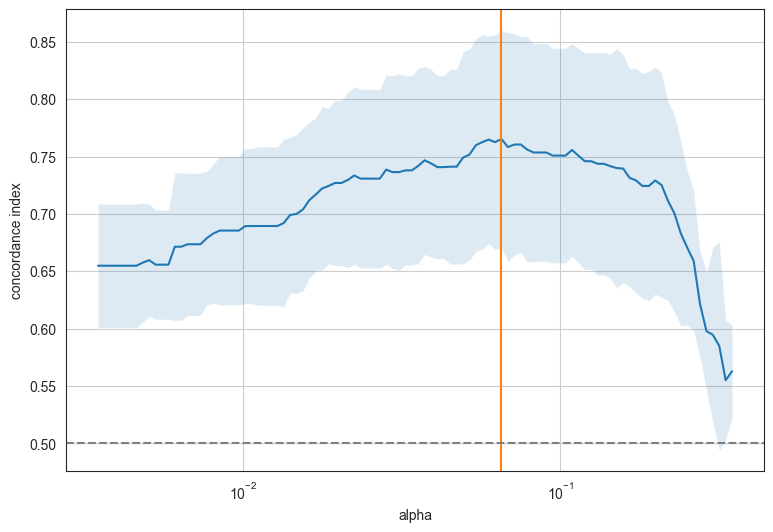

In [38]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [39]:
gcv.best_params_

{'coxnetsurvivalanalysis__alphas': [0.06538045982654901]}

Number of non-zero coefficients: 8


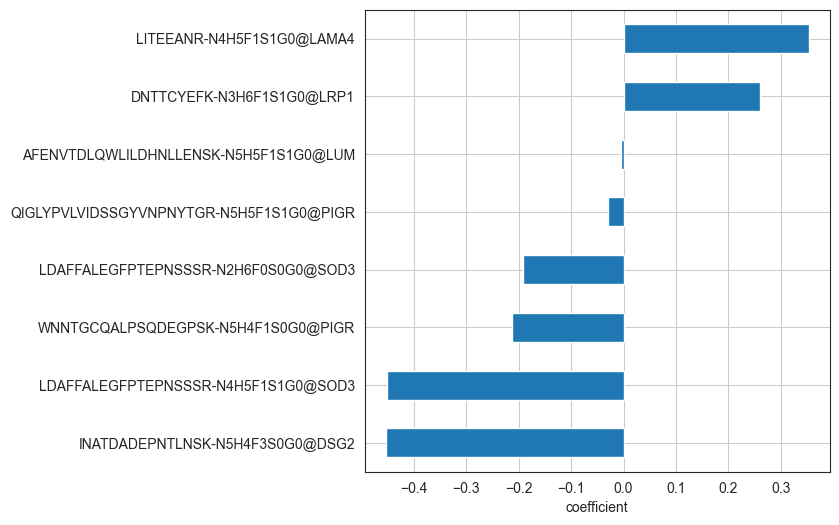

In [43]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=x_train.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 6))
# non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)

xdf = non_zero_coefs.loc[coef_order]
xdf.index = ['{}@{}'.format(i[0],i[1].split("|")[0]) for i in xdf.index]
xdf = xdf.sort_values(["coefficient"])
# xdf = pd.concat([xdf.iloc[:10,:],xdf.iloc[-10:,:]])
xdf.plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [44]:
ax.grid(True)
#%%
coxnet_pred = make_pipeline(
    # StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True)
)
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(x_train, y_train)

Pipeline(steps=[('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.06538045982654901],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

/Users/yingweihu/opt/anaconda3/envs/py39_glycositeatlas/lib/python3.9/site-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


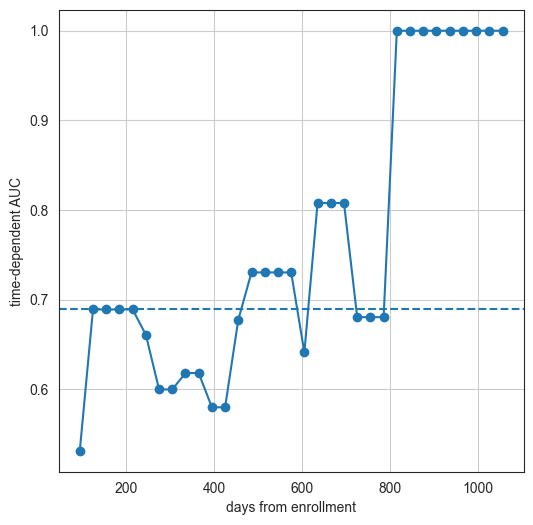

In [45]:
va_times = np.arange(35, 356*3, 30)
fig,ax = plt.subplots(figsize=(6,6))
cph_risk_scores = coxnet_pred.predict(x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, cph_risk_scores, va_times
)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(np.nanmedian(cph_auc), linestyle="--")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.grid(True)

In [46]:
#%%
np.nanmedian(cph_auc)

0.6888888888888889